# **Snack & Stream Planner: A JSON Agent Implementation**

# **Concept**
An intelligent planner that pairs Netflix or other streaming show recommendations with unique snack or meal ideas

## **Why This Implementation?**


* **Structured Interaction**: Uses JSON-defined tools for precise, schema-validated function calls
* **Robust Error Handling**: Leverages OpenAI's function calling interface for reliable tool execution
* **State Management**: Maintains structured chat history with clear role definitions
* **Enhanced Output Control**: Structured parsing of final responses for consistent formatting

## **Technical Stack**

* **LLM - Together AI's Llama-3.3-70B-Instruct-Turbo-Free**
* **uNoGS API**: for show or movie data
* **Spoonacular API**: for recipe suggestions

# **Flow Chart**

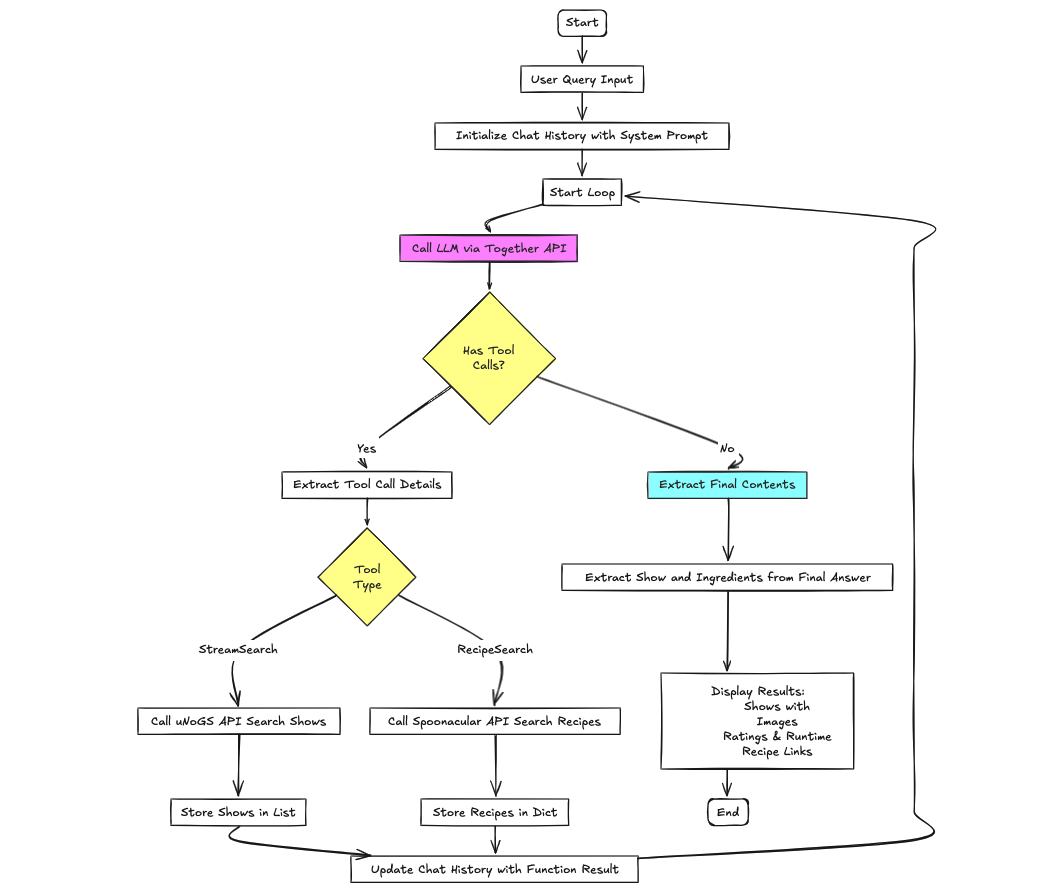

# Required Imports

In [ ]:
import json, re
from openai import OpenAI
from google.colab import userdata
import requests
from IPython.display import Image, HTML, display

# Define tools

In [ ]:
tools = [
    {
        # Defines this as a callable function
        "type": "function",
        "function": {
            # Function identifier
            "name": "StreamSearch",
            "description": "Search for streaming shows/movies. Use simple genres like action, comedy, horror, drama, romance, thriller.",
             # JSON Schema for function parameters
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {"type": "string", "description": "Genre to search for"}
                },
                # Parameter validation
                "required": ["query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "RecipeSearch",
            "description": "Search for recipes using basic ingredients like popcorn, cookies, nachos, brownies, guacamole.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {"type": "string", "description": "Ingredient to search for"}
                },
                "required": ["query"]
            }
        }
    }
]

# Initialize OpenAI client

In [ ]:
client = OpenAI(
    api_key=userdata.get("TOGETHER_API_KEY"),
    base_url="https://api.together.xyz/v1",
)

# Helper Functions

In [ ]:
def unogs_search(action_input: str):
    url = "https://unogsng.p.rapidapi.com/search"
    headers = {
        'x-rapidapi-key': userdata.get('RAPID_API_KEY'),
        'x-rapidapi-host': "unogsng.p.rapidapi.com"
    }
    params = {
        'query': action_input,
        'limit': '5',
        'orderby': 'rating'
    }
    try:
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        if data.get('results'):
            return {
                "shows": [
                    {
                        "title": show.get('title', 'Unknown Title'),
                        "description": show.get('synopsis', 'No description available'),
                        "watch_url": f"https://www.netflix.com/title/{show.get('nfid')}" if show.get('nfid') else "URL not available",
                        "image_url": show.get('img') or show.get('poster'),
                        "rating": f"IMDb: {show.get('imdbrating')}/10" if show.get('imdbrating') else "No rating available",
                        "type": show.get('vtype', 'unknown'),
                        "year": show.get('year', 'unknown')
                    } for show in data['results']
                ],
                "query": action_input,
                "total_results": data.get('total', 0)
            }
        return {"error": "No results found", "query": action_input}
    except requests.exceptions.RequestException as e:
        return {"error": f"API request failed: {str(e)}", "query": action_input}

In [ ]:
def get_recipe_suggestions(query: str):
    api_key = userdata.get('SPOONACULAR_API_KEY')
    url = f"https://api.spoonacular.com/recipes/complexSearch"
    params = {
        "apiKey": api_key,
        "query": query,
        "number": 2,
        "addRecipeInformation": True
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            return {
                "recipes": [
                    {
                        "title": recipe.get('title'),
                        "url": recipe.get('sourceUrl'),
                        "readyInMinutes": recipe.get('readyInMinutes')
                    } for recipe in data['results']
                ]
            }
    return {"error": "Unable to fetch recipes"}

# JSON Agent

In [ ]:
def extract_final_contents(final_answer: str, shows: list, recipes_dict: dict):
    """
    Extract the show and ingredients mentioned in the final answer.
    """
    # Extract show title
    show_pattern = r"Watching ([^?]+)\?"
    show_match = re.search(show_pattern, final_answer)
    selected_show = show_match.group(1).strip() if show_match else None

    # Extract ingredients from recipes
    recipes_pattern = r"How about [^()]+\(([^)]+)\) or [^()]+\(([^)]+)\)!"
    recipes_match = re.search(recipes_pattern, final_answer)
    selected_ingredients = []
    if recipes_match:
        selected_ingredients.extend([recipes_match.group(1).strip().lower(), recipes_match.group(2).strip().lower()])
        # Deduplicate ingredients
        selected_ingredients = list(set(selected_ingredients))

    return selected_show, selected_ingredients


def run_planner(user_query: str):
    # Initialize the chat history with system and user messages
    chat_history = [
        {
            "role": "system",
            "content": """
            You are a Snack & Stream Planner that suggests perfect food pairings for streaming content.
            Use the available tools to fetch streaming shows and corresponding recipes.
            Follow this style for your suggestions:
            "Watching [Show Name]? How about [Creative Snack Name] ([ingredient]) or [Another Creative Snack] ([ingredient])!"

            Available tools:
            1. StreamSearch: To find shows/movies based on genres.
            2. RecipeSearch: To find recipes based on snack ingredients.

            Always use these tools to gather information. Do not generate recipes on your own.
            """
        },
        {
            "role": "user",
            "content": f"Question: {user_query}"
        }
    ]

    # Initialize lists to store recommended shows and recipes
    recommended_shows = []
    recommended_recipes = {}

    while True:
        # Create a completion using the chat history and available tools
        completion = client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free",
            messages=chat_history,
            tools=tools
        )

        message = completion.choices[0].message
        if message.tool_calls:
            # Extract the tool call details
            tool_call = message.tool_calls[0]
            tool_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            print(f"\n=== Calling {tool_name} with arguments: {arguments} ===")

            if tool_name == "StreamSearch":
                # Call the StreamSearch function to get shows based on genre
                result = unogs_search(arguments['query'])
                print("StreamSearch Result:", json.dumps(result, indent=2))
                if "shows" in result:
                    recommended_shows.extend(result['shows'])

            elif tool_name == "RecipeSearch":
                # Call the RecipeSearch function to get recipes based on ingredient
                query_ingredient = arguments['query'].lower()
                result = get_recipe_suggestions(arguments['query'])
                print("RecipeSearch Result:", json.dumps(result, indent=2))
                if "recipes" in result:
                    if query_ingredient not in recommended_recipes:
                        recommended_recipes[query_ingredient] = []
                    # Avoid adding duplicate recipes
                    existing_titles = {recipe['title'] for recipe in recommended_recipes[query_ingredient]}
                    for recipe in result['recipes']:
                        if recipe['title'] not in existing_titles:
                            recommended_recipes[query_ingredient].append(recipe)

            # Append the function call and its result to the chat history
            chat_history.append(message)
            chat_history.append({
                "role": "function",
                "name": tool_name,
                "content": json.dumps(result)
            })
        else:
            # If no tool is called, capture the final answer
            final_answer = message.content
            break

    print("\n=== Final Answer ===")
    print(final_answer)

    # Extract the selected show and its ingredients from the final answer
    show, ingredients = extract_final_contents(final_answer, recommended_shows, recommended_recipes)

    # Display the selected show details
    if show:
        show_details = next((s for s in recommended_shows if s['title'].lower() == show.lower()), None)
        if show_details:
            print(f"\n📺 {show_details['title']} ({show_details['year']}) - {show_details['rating']}")
            print(f"📝 {show_details['description']}")
            print(f"🔗 Watch here: {show_details['watch_url']}")
            if show_details.get('image_url'):
                try:
                    display(Image(url=show_details['image_url']))
                except:
                    print("🔗 Image not available")
        else:
            print("\n📺 Show details not found.")
    else:
        print("\n📺 No specific show selected.")

    # Display the available recipes based on extracted ingredients
    if ingredients:
        print("\n=== Available Recipes for Your Snacks ===")
        all_recipes_displayed = set()  # To avoid duplicates across ingredients
        for ingredient in ingredients:
            recipes = recommended_recipes.get(ingredient, [])
            if recipes:
                print(f"\n🔍 Recipes for **{ingredient.capitalize()}**:")
                for recipe in recipes:
                    if recipe['title'] not in all_recipes_displayed:
                        all_recipes_displayed.add(recipe['title'])
                        print(f"\n🍳 {recipe['title']} - Ready in {recipe['readyInMinutes']} mins")
                        if recipe.get('url'):
                            display(HTML(f'<a href="{recipe["url"]}" target="_blank">👩‍🍳 View Recipe</a>'))
            else:
                print(f"\n🔍 No recipes found for ingredient: {ingredient}")
    else:
        print("\n🔍 No ingredients found to fetch recipes.")

    return final_answer

In [ ]:
# Example
query = "I want to watch something scary with appropriate snacks"
result = run_planner(query)
print("\nResult:", result)


=== Calling StreamSearch with arguments: {'query': 'horror'} ===
StreamSearch Result: {
  "shows": [
    {
      "title": "Hogwood: A Modern Horror Story",
      "description": "Exposing the jarring conditions inside one of Britain&#39;s largest pig farms, an activist group calls on the power players in animal agriculture for change.",
      "watch_url": "https://www.netflix.com/title/81471131",
      "image_url": "https://occ-0-7126-1490.1.nflxso.net/dnm/api/v6/oQyw8Fv9eE41UPapt7zHvdUdzrE/AAAABWlc057PeP3r37J9ZnOLXLPyhTYRTm3LMza_5gPqyDzTkcXGExwF4mAK2HgnBA3lbiHNbq60WXBR4oCXSlLl9shUEz3jT9rjmg.jpg?r=060",
      "rating": "IMDb: 8.3/10",
      "type": "movie",
      "year": 2020
    },
    {
      "title": "Circus of Horrors",
      "description": "After mutilating a patient, a plastic surgeon is booted from the medical profession and goes into hiding in this grisly cult classic.",
      "watch_url": "https://www.netflix.com/title/70025004",
      "image_url": "https://occ-0-4039-1500.1.n


=== Available Recipes for Your Snacks ===

🔍 Recipes for **Popcorn**:

🍳 Popcorn Ice Cream - Ready in 45 mins



🍳 Chocolate Popcorn - Ready in 45 mins



Result: Watching Two Sentence Horror Stories? How about Spicy Popcorn (popcorn) or Chocolate Popcorn (popcorn)!


In [ ]:
# Example
query = "I'm in the mood for a romantic comedy and would love some sweet snacks to enjoy"
result = run_planner(query)
print("\nResult:", result)


=== Calling StreamSearch with arguments: {'query': 'romance, comedy'} ===
StreamSearch Result: {
  "shows": [
    {
      "title": "Romance is a bonus book",
      "description": "A gifted writer who&#39;s the youngest editor-in-chief ever at his publishing company gets enmeshed in the life of a former copywriter desperate for a job.",
      "watch_url": "https://www.netflix.com/title/81045349",
      "image_url": "https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/evlCitJPPCVCry0BZlEFb5-QjKc/AAAABR-Xc35rLzWPfwILMlIMv_XdqKSwltYD7G2ihQW9FKYZrjJhFpAc4vHbwfS77aZn4Nm6Tg1LcutgFzJlB7jN6RWQTYiQvJjg2C10t6s_kgnUZBf8fg3XPFlmXRk.jpg?r=d2f",
      "rating": "IMDb: 8.1/10",
      "type": "series",
      "year": 2019
    },
    {
      "title": "The Romance of Tiger and Rose",
      "description": "When a screenwriter wakes up as a princess in the historical drama she&#39;s penning, she must maneuver to stay alive amid the threats of her own invention.",
      "watch_url": "https://www.netflix.com/title


=== Available Recipes for Your Snacks ===

🔍 No recipes found for ingredient: cheesecake brownies

🔍 Recipes for **Brownies**:

🍳 No-Bake Fudge Brandy Brownies - Ready in 45 mins



🍳 Skinny Cheesecake Brownie Bites - Ready in 25 mins



Result: Watching Romance is a bonus book? How about Chocolate Delight (brownies) or Cheesecake Bites (cheesecake brownies)!
